In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("bodyPerformance.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB


In [ ]:
def get_heat_map_corr(corr_df, figsize=(10, 9), remove_cols=[], corr_method='pearson', title=None):

    df_temp = corr_df
    for i in remove_cols:
        try:
            df_temp = df_temp.drop(i,axis=1)
        except:
            print(f'column {i} not found')

    corr = df_temp.corr(method=corr_method)

    f, ax = plt.subplots(figsize=figsize)

    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    if title != None:
        plt.title(title)

    # sns.heatmap(corr, annot=True, cmap=cmap)
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

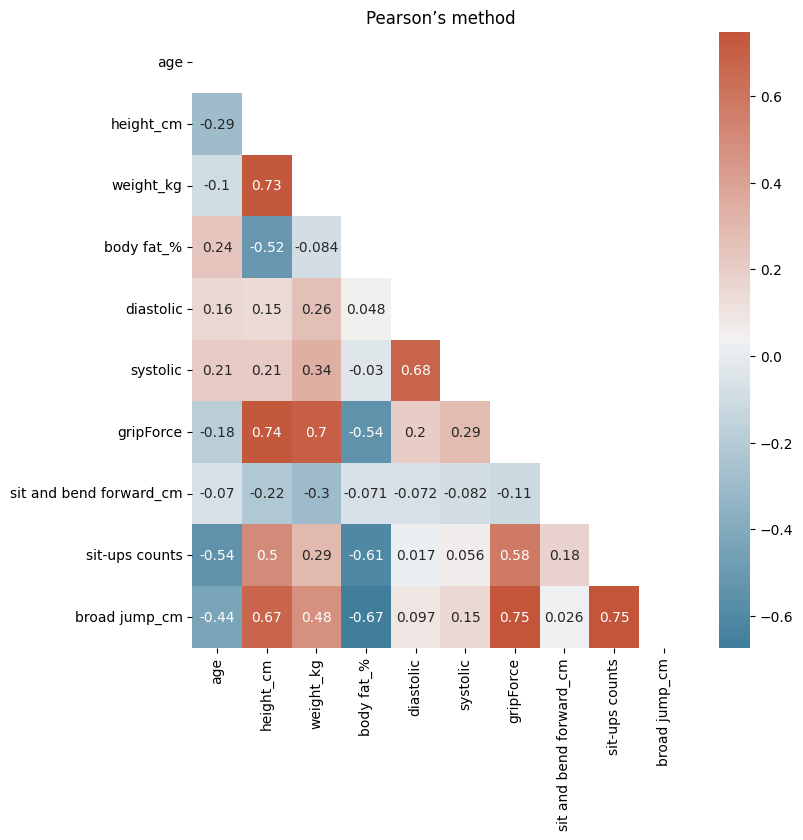

In [ ]:
# Pearson’s correlation coefficient
get_heat_map_corr(df, figsize=(8, 8), remove_cols = ['gender','class'], title="Pearson’s method")

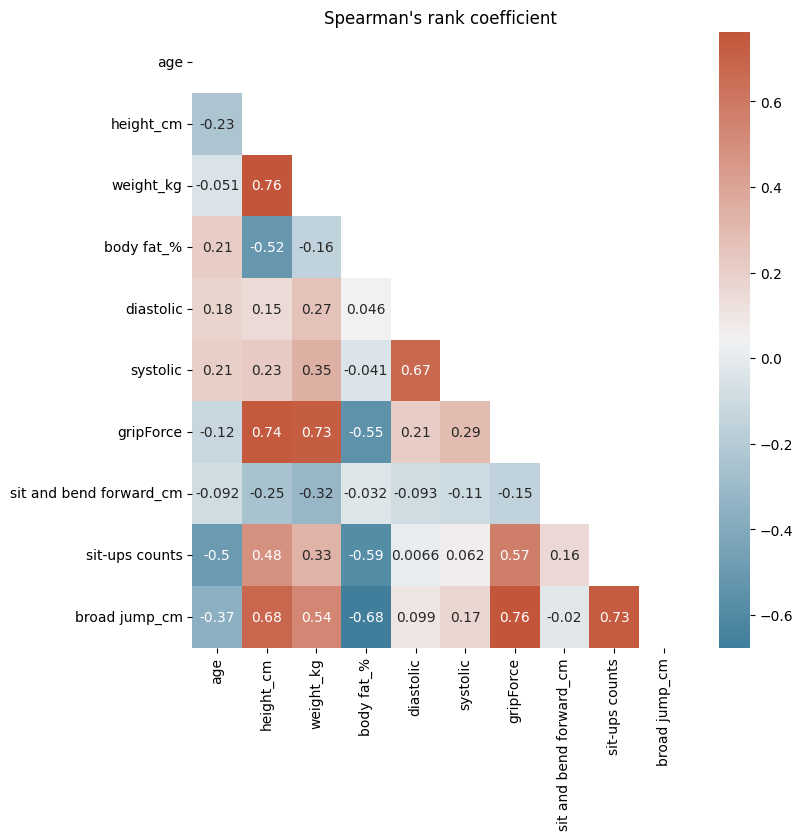

In [ ]:
# Spearman’s rank coefficient
get_heat_map_corr(df, figsize=(8, 8), remove_cols = ['gender','class'], corr_method='spearman', title="Spearman's rank coefficient")

Index(['age', 'gender', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic',
       'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts',
       'broad jump_cm', 'class'],
      dtype='object')


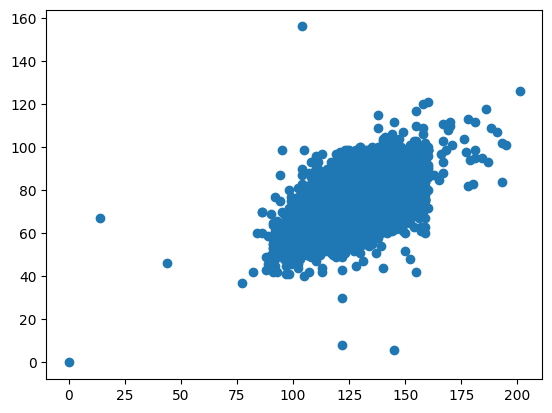

In [ ]:
print(df.columns)
plt.scatter(df["systolic"], df["diastolic"])

In [6]:
# adding 'blood_pressure' column
systolic = df['systolic'].astype(int).astype(str)
diastolic = df['diastolic'].astype(int).astype(str)
df['blood_pressure'] = systolic + "/" + diastolic

# placed 'blood_pressure' near 'systolic' and 'diastolic'
df = df[[
    'age',
    'gender',
    'height_cm',
    'weight_kg',
    'body fat_%',
    'diastolic',
    'systolic',
    'blood_pressure',
    'gripForce',
    'sit and bend forward_cm',
    'sit-ups counts',
    'broad jump_cm',
    'class',
    ]]

# Normal
# 	systolic:  less than 120
# 	diastolic: less than 80
# Elevated
# 	systolic:  120–129
# 	diastolic: less than 80
# High blood pressure (hypertension)
# 	systolic:  130 or higher
# 	diastolic: 80 or higher

# df[['systolic', 'diastolic']].value_counts().reset_index()
df[['diastolic']].describe()

,diastolic
count,13393.000000
mean,78.796842
std,10.742033
min,0.000000
25%,71.000000
50%,79.000000
75%,86.000000
max,156.200000


In [7]:
def interquartile_range_method(df_col):
    sort_df_col = df_col.sort_values()
    q1 = sort_df_col.quantile(0.25)
    q3 = sort_df_col.quantile(0.75)
    iqr = q3 - q1
    upper_fence = q3 + (1.5 * iqr)
    lower_fence = q1 - (1.5 * iqr)
    outliers = ((sort_df_col < lower_fence) | (sort_df_col > upper_fence))
    print(f"[{sort_df_col.name}] outliers: {outliers.sum()}")
    return outliers

def statistical_outlier_detection(df_col, get=False):
    data = df_col.to_numpy()
    mean,sigma = np.mean(data), np.std(data)     # standard deviation
    threshold = 3
    z = (data - mean)
    z /= sigma
    outliers = data[z > threshold]
    if get == False:
        return len(outliers)
    else:
        return outliers

[diastolic] outliers: 54


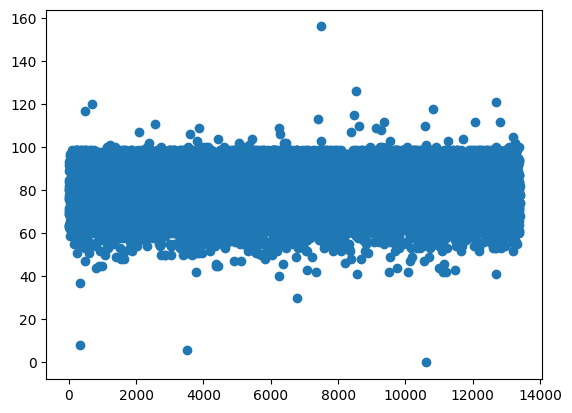

In [8]:
interquartile_range_method(df['diastolic'])
plt.scatter(df['diastolic'].index, df['diastolic'])

In [9]:
diastolic_out = statistical_outlier_detection(df['diastolic'], True)
diastolic_out = statistical_outlier_detection(df['diastolic'], True)
for o in diastolic_out:
    fil = df['diastolic'] == o
    df.loc[fil, 'diastolic'] = df['diastolic'].mean()

In [10]:
# VarianceThreshold

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder

X = df
X.nunique(axis=0)

# this is to encode string to numerical
ord_enc = OrdinalEncoder()
X[["gender","class"]] = ord_enc.fit_transform(X[["gender","class"]])

X = df.drop(["gender", "blood_pressure"],axis=1)
# X = df.drop(["gender", "blood_pressure", "class"],axis=1)

# threshold < 1.3 doesn't pick up 'class' column
var_thr = VarianceThreshold(threshold = 1.3)
var_thr.fit(X)
var_thr.get_support()

concol = [column for column in X.columns
          if column not in X.columns[var_thr.get_support()]]

# # for column in X.columns:
# for column in X.columns[var_thr.get_support()]:
#     print(column)

print("columns with low variance to delete:")
for features in concol:
    print(features)
    # X = X.drop(features, axis=1)

# # # sel = VarianceThreshold(threshold=.2)
# # # y=sel.fit_transform(X)
# # # print(y.shape)
# # # y

columns with low variance to delete:
class


In [11]:
# my version of VarianceThreshold
temp = df[:]
threshold = 4

for c in temp.columns:
    unique = temp[c].nunique()
    if unique <= threshold:
        print(c, unique)
        temp = temp.drop(c,axis=1)
temp.head()

gender 2
class 4


,age,height_cm,weight_kg,body fat_%,diastolic,systolic,blood_pressure,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,27.0,172.3,75.24,21.3,80.0,130.0,130/80,54.9,18.4,60.0,217.0
1,25.0,165.0,55.80,15.7,77.0,126.0,126/77,36.4,16.3,53.0,229.0
2,31.0,179.6,78.00,20.1,92.0,152.0,152/92,44.8,12.0,49.0,181.0
3,32.0,174.5,71.10,18.4,76.0,147.0,147/76,41.4,15.2,53.0,219.0
4,28.0,173.8,67.70,17.1,70.0,127.0,127/70,43.5,27.1,45.0,217.0


In [12]:
# look if there are any other values than 'M' of 'F' in 'gender'
df['gender'].value_counts()
df['gender'].info()

# get all 'M' in 'gender' column
m = df["gender"] == "M"

# # create a new col
# df["gender_num"] = df['gender']
# # rearange columns
# df = df[['age','gender','gender_num','height_cm','weight_kg','body fat_%','diastolic','systolic','blood_pressure','gripForce','sit and bend forward_cm','sit-ups counts','broad jump_cm','class',
# ]]

# replace 'M' to 0 and 'F' to 1
# df["gender_num"] = 0 if df["gender"] == "M" else 1
df.loc[m,"gender_num"] = 0
df.loc[~m,"gender_num"] = 1


df.head(20)

<class 'pandas.core.series.Series'>
RangeIndex: 13393 entries, 0 to 13392
Series name: gender
Non-Null Count  Dtype  
--------------  -----  
13393 non-null  float64
dtypes: float64(1)
memory usage: 104.8 KB


,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,blood_pressure,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class,gender_num
0,27.0,1.0,172.3,75.24,21.3,80.0,130.0,130/80,54.9,18.4,60.0,217.0,2.0,1.0
1,25.0,1.0,165.0,55.80,15.7,77.0,126.0,126/77,36.4,16.3,53.0,229.0,0.0,1.0
2,31.0,1.0,179.6,78.00,20.1,92.0,152.0,152/92,44.8,12.0,49.0,181.0,2.0,1.0
3,32.0,1.0,174.5,71.10,18.4,76.0,147.0,147/76,41.4,15.2,53.0,219.0,1.0,1.0
4,28.0,1.0,173.8,67.70,17.1,70.0,127.0,127/70,43.5,27.1,45.0,217.0,1.0,1.0
5,36.0,0.0,165.4,55.40,22.0,64.0,119.0,119/64,23.8,21.0,27.0,153.0,1.0,1.0
6,42.0,0.0,164.5,63.70,32.2,72.0,135.0,135/72,22.7,0.8,18.0,146.0,3.0,1.0
7,33.0,1.0,174.9,77.20,36.9,84.0,137.0,137/84,45.9,12.3,42.0,234.0,1.0,1.0
8,54.0,1.0,166.8,67.50,27.6,85.0,165.0,165/85,40.4,18.6,34.0,148.0,2.0,1.0
9,28.0,1.0,185.0,84.60,14.4,81.0,156.0,156/81,57.9,12.1,55.0,213.0,1.0,1.0


Text(0.5, 1.0, 'Information Gain')

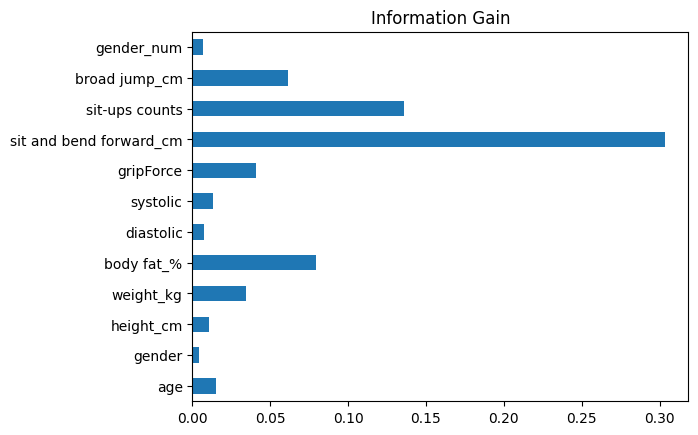

In [13]:
# Information Gain
from sklearn.feature_selection import mutual_info_classif

X = df.drop(['class','blood_pressure'],axis=1)
y = df['class']

importances = mutual_info_classif(X,y)
importances
importances.shape
feat_importance = pd.Series(importances,X.columns)
feat_importance.plot(kind='barh')
plt.title("Information Gain")

In [18]:
# Chi-square Test

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X = df.drop(['class','blood_pressure'], axis=1)
y = df['class']

X=X.abs() # Input X must be non-negative for fit_transform()

chi2_features = SelectKBest(chi2, k=6)
X_kbest_feat = chi2_features.fit_transform(X,y)

print(X.shape)
print(X_kbest_feat.shape)
# X_kbest_feat

(13393, 12)
(13393, 6)


Text(0.5, 1.0, 'Mean Absolute Difference (MAD)')

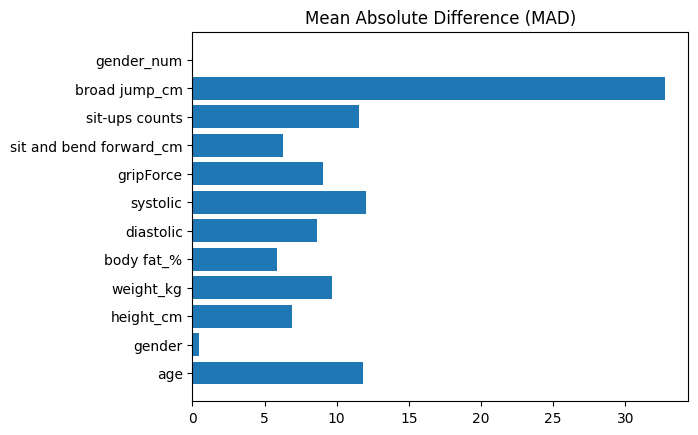

In [14]:
# Mean Absolute Difference (MAD)
# higher the MAD, the higher the discriminatory power.

X = df.drop(['blood_pressure'], axis=1)
X = df.drop(['class','blood_pressure'], axis=1)

mean_abs_diff = np.sum( np.abs (X-np.mean(X, axis =0)), axis = 0) / X.shape[0]
# plt.(np.arange(X.shape[1]), mean_abs_diff, color = 'teal', width=.3)
# plt.bar(np.arange(mean_abs_diff.size), mean_abs_diff)
plt.barh(X.columns, mean_abs_diff)

plt.title("Mean Absolute Difference (MAD)")

In [15]:
# Random Forest Importance
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300)

X = df.drop(['class','blood_pressure'], axis=1)
y = df['class']
model.fit(X,y)

RandomForestClassifier(n_estimators=300)

Text(0.5, 1.0, 'Random Forest Importance')

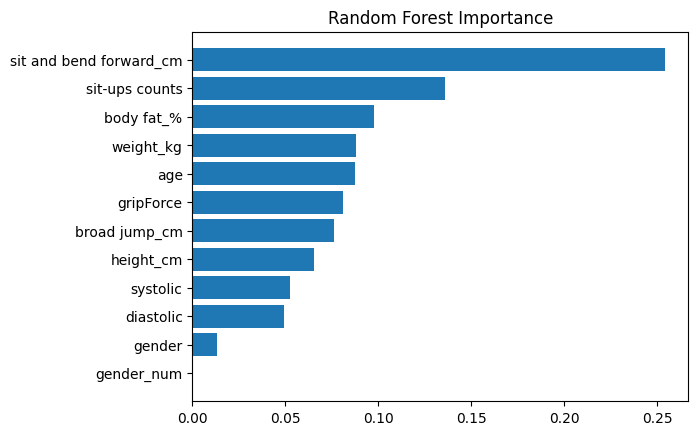

In [16]:
# Random Forest Importance
importances = model.feature_importances_

temp = pd.DataFrame({
    'features': pd.DataFrame(X).columns,
    'importance': importances,
    })
# temp = temp.set_index('importance')
temp = temp.sort_values('importance')
plt.barh(temp['features'],temp['importance'])
plt.title("Random Forest Importance")

In [17]:
# Embedded method Lasso

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

X = df.drop(['class','blood_pressure'], axis=1)
y = df['class']

lasso = Lasso(alpha=0.2)
lasso.fit(X, y)

selected_features = X.columns[lasso.coef_ != 0]

df[selected_features]
# print(df is df[selected_features])

,age,weight_kg,diastolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
0,27.0,75.24,80.0,54.9,18.4,60.0,217.0
1,25.0,55.80,77.0,36.4,16.3,53.0,229.0
2,31.0,78.00,92.0,44.8,12.0,49.0,181.0
3,32.0,71.10,76.0,41.4,15.2,53.0,219.0
4,28.0,67.70,70.0,43.5,27.1,45.0,217.0
...,...,...,...,...,...,...,...
13388,25.0,71.80,74.0,35.8,17.4,47.0,198.0
13389,21.0,63.90,74.0,33.0,1.1,48.0,167.0
13390,39.0,80.50,78.0,63.5,16.4,45.0,229.0
13391,64.0,57.70,68.0,19.3,9.2,0.0,75.0


In [19]:
# Forward Feature Selection
from sklearn.model_selection import train_test_split

X = df.drop(['class','blood_pressure'], axis=1)
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.3, random_state=100)

In [20]:
# google colab part
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

In [21]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
forward_feature_selection = SequentialFeatureSelector(
    RandomForestClassifier(n_jobs=-1),
    k_features=X_train.shape[1]-2,
    forward=True,
    floating=False,
    verbose=2,
    scoring='accuracy',
    cv = 5,
)
forward_feature_selection.fit(X_train,y_train)
# X_train.shape[1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   49.1s finished

[2023-06-28 11:27:41] Features: 1/10 -- score: 0.4667733333333334[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:   46.2s finished

[2023-06-28 11:28:28] Features: 2/10 -- score: 0.5041066666666667[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   44.8s finished

[2023-06-28 11:29:12] Features: 3/10 -- score: 0.5297066666666665[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

SequentialFeatureSelector(estimator=RandomForestClassifier(n_jobs=-1),
                          k_features=10, scoring='accuracy', verbose=2)

In [22]:
forward_feature_selection.k_feature_idx_
forward_feature_selection.k_feature_names_
# forwart_feature_selection.k_score_

('age',
 'gender',
 'weight_kg',
 'body fat_%',
 'diastolic',
 'gripForce',
 'sit and bend forward_cm',
 'sit-ups counts',
 'broad jump_cm',
 'gender_num')

In [23]:
pd.DataFrame.from_dict(forward_feature_selection.get_metric_dict())

,1,2,3,4,5,6,7,8,9,10
feature_idx,"(8,)","(1, 8)","(1, 8, 9)","(0, 1, 8, 9)","(0, 1, 4, 8, 9)","(0, 1, 4, 8, 9, 10)","(0, 1, 3, 4, 8, 9, 10)","(0, 1, 3, 4, 7, 8, 9, 10)","(0, 1, 3, 4, 7, 8, 9, 10, 11)","(0, 1, 3, 4, 5, 7, 8, 9, 10, 11)"
cv_scores,"[0.45226666666666665, 0.4768, 0.45013333333333...","[0.49333333333333335, 0.5066666666666667, 0.48...","[0.5306666666666666, 0.5274666666666666, 0.529...","[0.6986666666666667, 0.6805333333333333, 0.675...","[0.7157333333333333, 0.7210666666666666, 0.712...","[0.728, 0.7349333333333333, 0.7242666666666666...","[0.7354666666666667, 0.7408, 0.7296, 0.7317333...","[0.7429333333333333, 0.7386666666666667, 0.730...","[0.7466666666666667, 0.7397333333333334, 0.731...","[0.7402666666666666, 0.7424, 0.731733333333333..."
avg_score,0.466773,0.504107,0.529707,0.685653,0.716587,0.7264,0.729173,0.731093,0.735573,0.7344
feature_names,"(sit and bend forward_cm,)","(gender, sit and bend forward_cm)","(gender, sit and bend forward_cm, sit-ups counts)","(age, gender, sit and bend forward_cm, sit-ups...","(age, gender, body fat_%, sit and bend forward...","(age, gender, body fat_%, sit and bend forward...","(age, gender, weight_kg, body fat_%, sit and b...","(age, gender, weight_kg, body fat_%, gripForce...","(age, gender, weight_kg, body fat_%, gripForce...","(age, gender, weight_kg, body fat_%, diastolic..."
ci_bound,0.017613,0.014711,0.001701,0.011957,0.006277,0.006268,0.014296,0.01473,0.010597,0.008317
std_dev,0.013703,0.011446,0.001324,0.009303,0.004883,0.004876,0.011123,0.011461,0.008244,0.006471
std_err,0.006852,0.005723,0.000662,0.004651,0.002442,0.002438,0.005562,0.00573,0.004122,0.003235
